# IMPORT

In [1]:
from scipy.io import loadmat
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import time
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
import ot 
from itertools import combinations 

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import euclidean_distances

## Surf

In [2]:
#Amazon
A_surf = loadmat('surf/amazon.mat')
X_a_surf = A_surf['fts']
Y_a_surf = A_surf['labels']

#Caltech
C_surf = loadmat('surf/caltech10.mat')
X_c_surf = C_surf['fts']
Y_c_surf = C_surf['labels']

# Webcam
W_surf = loadmat('surf/webcam.mat')
X_w_surf = W_surf['fts']
Y_w_surf = W_surf['labels']

# Dslr
D_surf = loadmat('surf/dslr.mat')
X_d_surf = D_surf['fts']
Y_d_surf = D_surf['labels']


In [3]:
print(X_w_surf.shape)
print(Y_w_surf.shape)
print(X_d_surf.shape)
print(Y_d_surf.shape)

(295, 800)
(295, 1)
(157, 800)
(157, 1)


# Without optimal transport

In [4]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_w_surf, Y_w_surf.ravel())
print("The accuracy is "+str(knn.score(X_d_surf, Y_d_surf)*100)+"%")

The accuracy is 56.05095541401274%


# Subspace Alignment

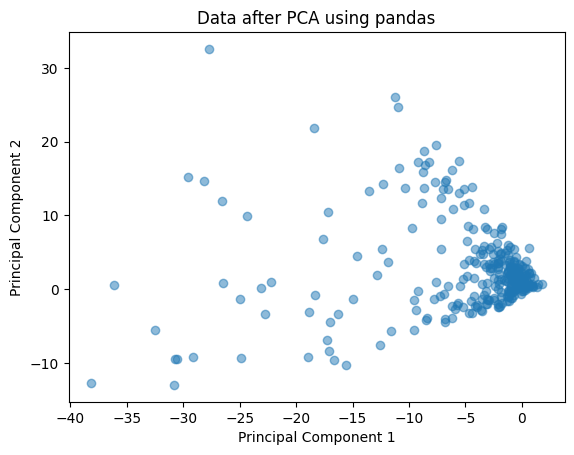

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(X_w_surf)
# Calculate the covariance matrix
cov_matrix = df.cov()

# Get the eigenvalues and eigenvectors
eigen_values, eigen_vectors = np.linalg.eig(cov_matrix)

# Sort the eigenvectors by decreasing eigenvalues
sorted_index = np.argsort(eigen_values)[::-1]
sorted_eigenvalue = eigen_values[sorted_index]
sorted_eigenvectors = eigen_vectors[:, sorted_index]

# Transform the data
X_w_surf_pandas = np.dot(X_w_surf, sorted_eigenvectors)

# Visualize the transformed data
plt.scatter(X_w_surf_pandas[:, 0], X_w_surf_pandas[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Data after PCA using pandas')
plt.show()


In [7]:
for i in range(len(sorted_eigenvalue)):
    sorted_eigenvalue[i]

In [8]:
np.sum(abs(sorted_eigenvalue)>0.0001)

294

Calculate optimal d_max bound

In [186]:
def max_d_optimal(source, target):
    scaler = StandardScaler()
    norm_source=scaler.fit_transform(source)
    norm_target=scaler.fit_transform(target)

    n = min(source.shape[0],target.shape[0])
    
    df_source = pd.DataFrame(norm_source)
    df_target = pd.DataFrame(norm_target)

    cov_source = df_source.cov()
    cov_target = df_target.cov()
    # Get the eigenvalues and eigenvectors
    eigen_values_source, _ = np.linalg.eig(cov_source)
    eigen_values_target, _ = np.linalg.eig(cov_target)
    #eigen_values_source = eigen_values_source[eigen_values_source.imag >0]
    #eigen_values_target = eigen_values_target[eigen_values_target.imag >0]
    
    eigen_values_source, eigen_values_target = abs(eigen_values_source), abs(eigen_values_target) 
    a = np.sort((eigen_values_source))[::-1]
    b = np.sort((eigen_values_target))[::-1]
    a = a[:n]
    b = b[:n]
    a_dif = a[0:-2]-a[1:-1]
    b_dif = b[0:-2]-b[1:-1]
    dif = np.stack((a_dif,b_dif)).T

    eigens = np.stack((a,b)).T
    eigens_mim = np.min(eigens,axis=1)
    eigens_mim_d_1 = eigens_mim[1:-1]
    eigens_mim_d_0 = eigens_mim[0:-2]
    #print(eigens.shape)
    #eigens_min = np.min(eigens, axis=0)
    return a, np.min((a_dif, b_dif), axis=0) 

def bound(delta, gamma, d_last, n_min, B=1):
    d = np.arange(d_last)
    b = (1+np.sqrt((np.log(2)/delta)/2)) *(16*d**(3/2)*B)/(gamma*np.sqrt(n_min))
    return b
        

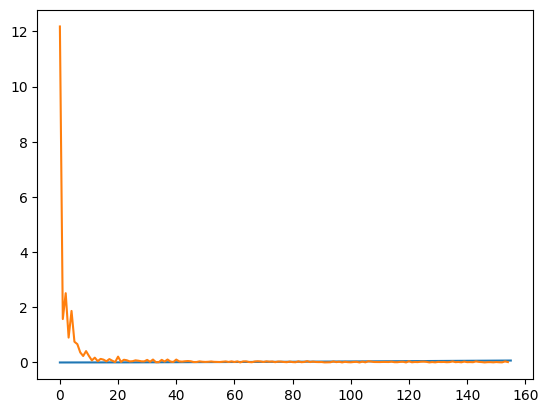

In [194]:
a , d_dif_min = max_d_optimal(X_w_surf,X_d_surf)
bound_dc = bound(delta=0.1, gamma=100000, d_last=156, n_min=157, B=1)
plt.plot(bound_dc)
plt.plot(d_dif_min)

/tmp/ipykernel_4124/165697035.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(bound_dc))


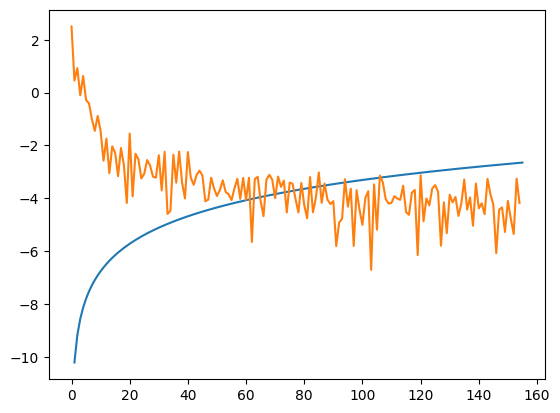

In [195]:
plt.plot(np.log(bound_dc))
plt.plot(np.log(d_dif_min))

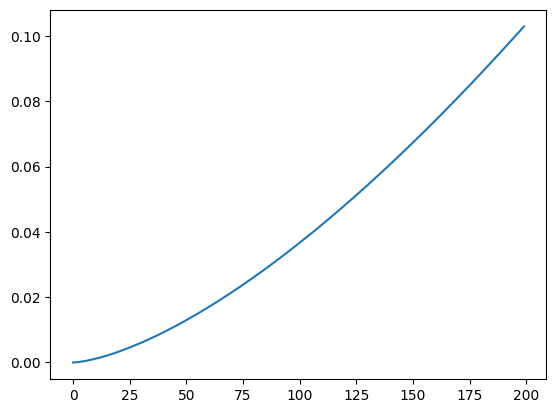

In [192]:
bound_dc = bound(delta=0.1, gamma=100000, d_last=200, n_min=156, B=1)
plt.plot(bound_dc)

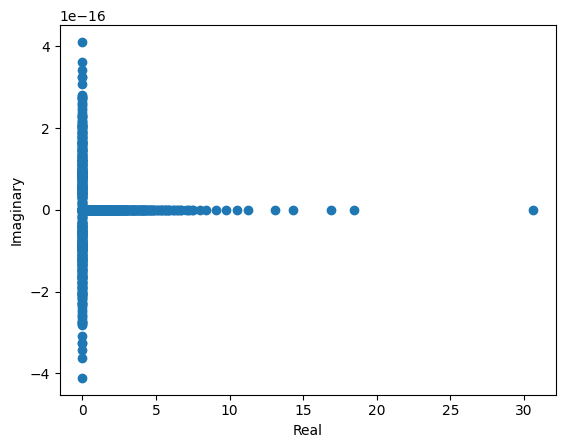

In [160]:
# extract real part 
x = [ele.real for ele in compl] 
# extract imaginary part 
y = [ele.imag for ele in compl] 
  
# plot the complex numbers 
plt.scatter(x, y) 
plt.ylabel('Imaginary') 
plt.xlabel('Real') 
plt.show() 

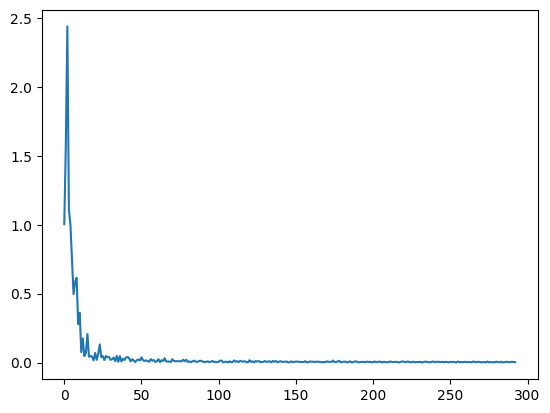

In [148]:
plt.plot(np.min((trasha, trashb), axis=0))

In [151]:
print(trashb[0:4])
print(trasha[0:4])
print(np.min((trasha[0:4], trashb[0:4]), axis=0))

[12.17967946+0.j  1.57414158+0.j  2.53180623+0.j  1.20685122+0.j]
[ 1.00409861 15.10913229  2.43905279  1.11125555]
[1.00409861+0.j 1.57414158+0.j 2.43905279+0.j 1.11125555+0.j]


/home/erick/Documents/otproject/envot/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/erick/Documents/otproject/envot/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


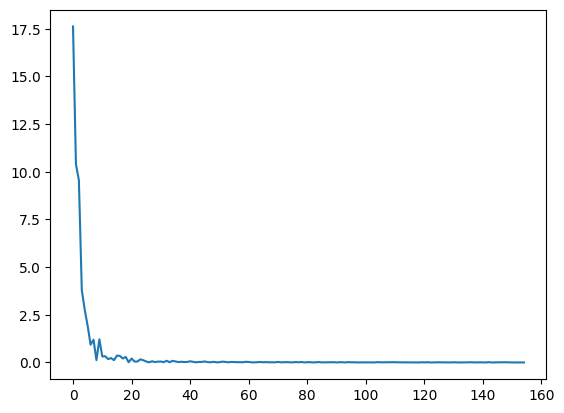

In [131]:
plt.plot(trashc[0:-2]-trashc[1:-1])

In [130]:
trashc

array([55.03085672+0.j, 37.41384856+0.j, 27.01925067+0.j, 17.46278003+0.j,
       13.67254105+0.j, 10.90742596+0.j,  8.98570852+0.j,  8.05356437+0.j,
        6.86052509+0.j,  6.73466317+0.j,  5.51962961+0.j,  5.20642634+0.j,
        4.876896  +0.j,  4.6997867 +0.j,  4.46728558+0.j,  4.34457988+0.j,
        3.98213775+0.j,  3.63619113+0.j,  3.42658589+0.j,  3.13381168+0.j,
        3.12092155+0.j,  2.91521901+0.j,  2.86501412+0.j,  2.81458462+0.j,
        2.6482736 +0.j,  2.53120914+0.j,  2.47887177+0.j,  2.47037591+0.j,
        2.40670967+0.j,  2.38342372+0.j,  2.33881566+0.j,  2.28895032+0.j,
        2.27095265+0.j,  2.18185272+0.j,  2.16708254+0.j,  2.08122097+0.j,
        2.02445727+0.j,  2.00209664+0.j,  1.96352569+0.j,  1.93772144+0.j,
        1.91008829+0.j,  1.84677575+0.j,  1.81298231+0.j,  1.80536804+0.j,
        1.77635793+0.j,  1.74559037+0.j,  1.69148996+0.j,  1.67151748+0.j,
        1.65829976+0.j,  1.62226418+0.j,  1.61318262+0.j,  1.5997549 +0.j,
        1.55383149+0.j,  

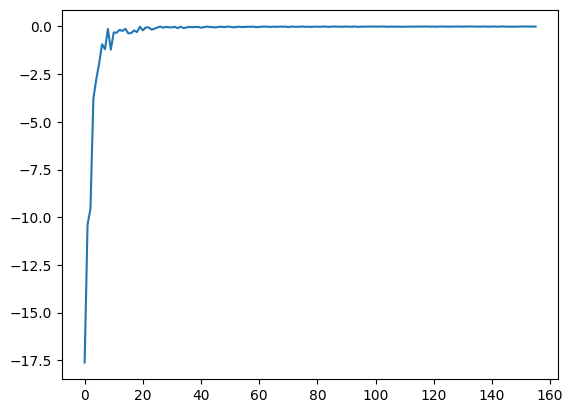

In [129]:
plt.plot(np.min((trashb, trasha), axis=0))

/home/erick/Documents/otproject/envot/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/erick/Documents/otproject/envot/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


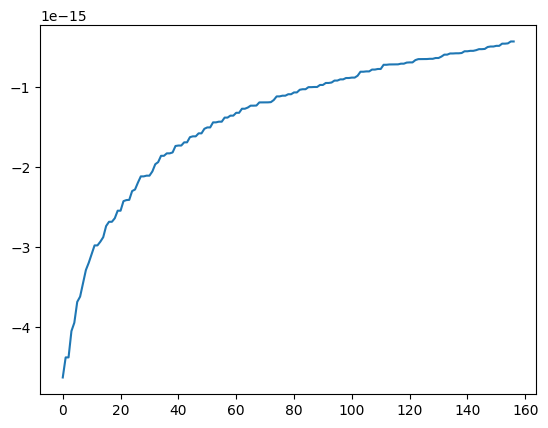

In [103]:
plt.plot(trasha)

In [93]:
np.min(trashb, axis=1).shape

(155,)

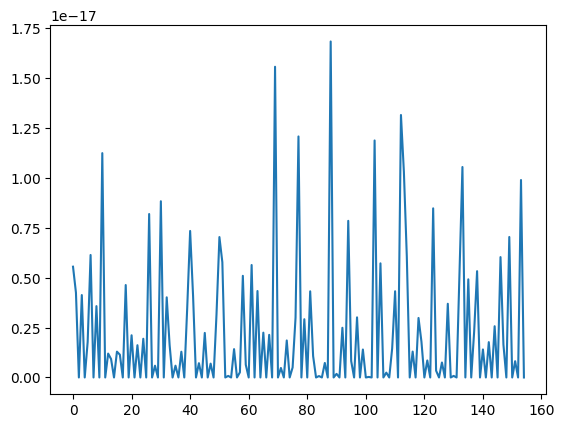

In [90]:
plt.plot(trashb)

In [75]:
trashb[1:-1]-trashb[0:-2]

array([[5.54324050e-18, 5.54324050e-18],
       [4.24510781e-18, 4.24510781e-18],
       [0.00000000e+00, 0.00000000e+00],
       [4.12398380e-18, 4.12398380e-18],
       [0.00000000e+00, 0.00000000e+00],
       [1.77534653e-18, 1.77534653e-18],
       [6.12919477e-18, 6.12919477e-18],
       [0.00000000e+00, 0.00000000e+00],
       [3.57028493e-18, 3.57028493e-18],
       [0.00000000e+00, 0.00000000e+00],
       [1.12250691e-17, 1.12250691e-17],
       [0.00000000e+00, 0.00000000e+00],
       [1.19557409e-18, 1.19557409e-18],
       [9.21331943e-19, 9.21331943e-19],
       [0.00000000e+00, 0.00000000e+00],
       [1.29220153e-18, 1.29220153e-18],
       [1.14058048e-18, 1.14058048e-18],
       [0.00000000e+00, 0.00000000e+00],
       [4.62575485e-18, 4.62575485e-18],
       [0.00000000e+00, 0.00000000e+00],
       [2.11186089e-18, 2.11186089e-18],
       [0.00000000e+00, 0.00000000e+00],
       [1.61448746e-18, 1.61448746e-18],
       [0.00000000e+00, 0.00000000e+00],
       [1.937276

In [47]:
trashb

array([ 5.50308567e+01+0.00000000e+00j,  3.74138486e+01+0.00000000e+00j,
        2.70192507e+01+0.00000000e+00j,  1.74627800e+01+0.00000000e+00j,
        1.36725411e+01+0.00000000e+00j,  1.09074260e+01+0.00000000e+00j,
        8.98570852e+00+0.00000000e+00j,  8.05356437e+00+0.00000000e+00j,
        6.73466317e+00+0.00000000e+00j,  6.86052509e+00+0.00000000e+00j,
        5.51962961e+00+0.00000000e+00j,  5.20642634e+00+0.00000000e+00j,
        4.87689600e+00+0.00000000e+00j,  4.69978670e+00+0.00000000e+00j,
        4.46728558e+00+0.00000000e+00j,  4.34457988e+00+0.00000000e+00j,
        3.98213775e+00+0.00000000e+00j,  3.63619113e+00+0.00000000e+00j,
        3.42658589e+00+0.00000000e+00j,  3.13381168e+00+0.00000000e+00j,
        3.12092155e+00+0.00000000e+00j,  2.91521901e+00+0.00000000e+00j,
        2.86501412e+00+0.00000000e+00j,  2.81458462e+00+0.00000000e+00j,
        2.64827360e+00+0.00000000e+00j,  2.53120914e+00+0.00000000e+00j,
        2.47887177e+00+0.00000000e+00j,  2.47037591

In [43]:
trasha.shape

(157, 2)

In [36]:
trashb

array([ 5.50308567e+01+0.00000000e+00j,  3.74138486e+01+0.00000000e+00j,
        2.70192507e+01+0.00000000e+00j,  1.74627800e+01+0.00000000e+00j,
        1.36725411e+01+0.00000000e+00j,  1.09074260e+01+0.00000000e+00j,
        8.98570852e+00+0.00000000e+00j,  8.05356437e+00+0.00000000e+00j,
        6.73466317e+00+0.00000000e+00j,  6.86052509e+00+0.00000000e+00j,
        5.51962961e+00+0.00000000e+00j,  5.20642634e+00+0.00000000e+00j,
        4.87689600e+00+0.00000000e+00j,  4.69978670e+00+0.00000000e+00j,
        4.46728558e+00+0.00000000e+00j,  4.34457988e+00+0.00000000e+00j,
        3.98213775e+00+0.00000000e+00j,  3.63619113e+00+0.00000000e+00j,
        3.42658589e+00+0.00000000e+00j,  3.13381168e+00+0.00000000e+00j,
        3.12092155e+00+0.00000000e+00j,  2.91521901e+00+0.00000000e+00j,
        2.86501412e+00+0.00000000e+00j,  2.81458462e+00+0.00000000e+00j,
        2.64827360e+00+0.00000000e+00j,  2.53120914e+00+0.00000000e+00j,
        2.47887177e+00+0.00000000e+00j,  2.47037591

In [37]:
def sub_align(S,S_y,T, T_y, stratified=True ):
    """ INPUT: S is the source features, S_y is the source label, T is the target label, T_y is the target features
        OUTPUT: list_score is a list with the average score of crossvalidation
                best_d is the dimension with the best average score
                score_in_target is the score in the aligend space using the best_d
                score_in_baseline is the 1-KNN only using the source data to classify the target label"""
    #Normalization
    scaler = StandardScaler()
    S=scaler.fit_transform(S)
    T=scaler.fit_transform(T)
    list_score = []
    list_Xs = []
    list_Xa = []
    list_Xt = []
    max_d=min([S.shape[0],S.shape[1],T.shape[0]])
    if stratified==True:
        folding = StratifiedKFold(5,shuffle=True, random_state=42)
    else:
        folding = KFold(5, shuffle=True, random_state=42)

    for d in range(1,max_d+1):
        pca = PCA(n_components=d, svd_solver='full')
        
        pca.fit(S)
        Xs=pca.components_.T
        list_Xs.append(Xs)
        pca.fit(T)
        Xt=pca.components_.T
        list_Xt.append(Xt)
        
        Xa=Xs@Xs.T@Xt
        Sa=S@Xa
        list_Xa.append(Xa)

        #St=T@Xt

        knn = KNeighborsClassifier(n_neighbors=1)
        #clf = fit.SVC(kernel='linear', C=1, random_state=42)
        scores = cross_val_score(knn, Sa, S_y.ravel(), cv=folding )
        avescore = np.average(scores)
        #print(f'd {d} and score {scores}')
        list_score.append(avescore)
    best_d = np.argmax(np.asarray(list_score))

    pca = PCA(n_components=best_d+1)
        
    pca.fit(S)
    Xs=pca.components_.T
    
    pca.fit(T)
    Xt=pca.components_.T
    
    Xa=Xs@Xs.T@Xt
    print(Xa.shape)
    Sa=S@Xa
    St=T@Xt
    knn.fit(Sa,S_y.ravel())
    score_in_target = knn.score(St, T_y.ravel())

    knn_baseline = KNeighborsClassifier(n_neighbors=1)
    knn_baseline.fit(S, S_y.ravel() )
    score_in_baseline = knn_baseline.score(T, T_y.ravel())
   
    return list_score, best_d+1, score_in_target, score_in_baseline, list_Xa, list_Xs, list_Xt





In [38]:
list_score_w_to_d, best_d_w_to_d, score_in_target_w_to_d, score_in_baseline_w_to_d, list_Xa_w_to_d, list_Xs_w_to_d, list_Xt_w_to_d = sub_align(X_w_surf,Y_w_surf,X_d_surf,Y_d_surf)
list_score_w_to_c, best_d_w_to_c, score_in_target_w_to_c, score_in_baseline_w_to_c, list_Xa_w_to_c, list_Xs_w_to_c, list_Xt_w_to_c = sub_align(X_w_surf,Y_w_surf,X_c_surf,Y_c_surf)
list_score_w_to_a, best_d_w_to_a, score_in_target_w_to_a, score_in_baseline_w_to_a, list_Xa_w_to_a, list_Xs_w_to_a, list_Xt_w_to_a = sub_align(X_w_surf,Y_w_surf,X_a_surf,Y_a_surf)

(800, 78)
(800, 24)
(800, 54)


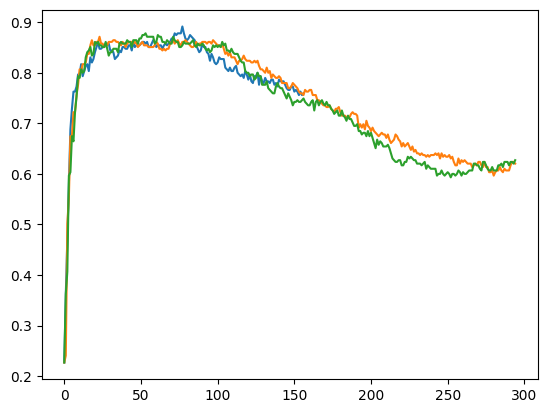

In [34]:
plt.plot(list_score_w_to_d)
plt.plot(list_score_w_to_c)
plt.plot(list_score_w_to_a)


In [69]:
import numpy as np
from sklearn.manifold import TSNE
scaler = StandardScaler()
w_projects_on_Xs = scaler.fit_transform(X_w_surf) @ list_Xs_w_to_d[20]
w_Xs_tsn = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=5).fit_transform(w_projects_on_Xs) 

w_Xs_tsn.shape

w_projects_on_Xa = scaler.fit_transform(X_w_surf) @ list_Xa_w_to_d[20]
w_Xa_tsn = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=5).fit_transform(w_projects_on_Xa) 

w_Xa_tsn.shape

d_projects_on_Xt = scaler.fit_transform(X_d_surf) @ list_Xt_w_to_d[20]
d_Xt_tsn = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=5).fit_transform(d_projects_on_Xt) 

d_Xt_tsn.shape

(157, 2)

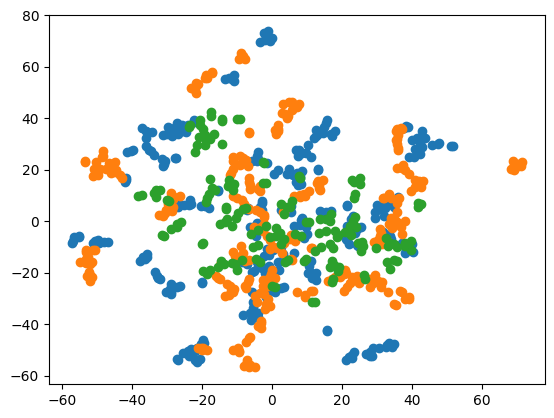

In [70]:
plt.scatter(w_Xs_tsn[:,0],w_Xs_tsn[:,1])
plt.scatter(w_Xa_tsn[:,0],w_Xa_tsn[:,1])
plt.scatter(d_Xt_tsn[:,0],d_Xt_tsn[:,1])



In [44]:
score_in_target_w_to_d, score_in_baseline_w_to_d

(0.9044585987261147, 0.3057324840764331)

In [45]:
score_in_target_w_to_c, score_in_baseline_w_to_c

(0.2840605520926091, 0.1923419412288513)

In [46]:
score_in_target_w_to_a, score_in_baseline_w_to_a

(0.3079331941544885, 0.17536534446764093)

# Entropic regularized optimal transport

In [4]:
def knn_ot(S,S_y,T, T_y, reg):
        #Normalization
    scaler = StandardScaler()
    S=scaler.fit_transform(S)
    T=scaler.fit_transform(T)
    
    a = np.repeat(1/S.shape[0], S.shape[0])
    b = np.repeat(1/T.shape[0], T.shape[0])
    M = cdist(S,T)
    M /= np.max(M)
    coupling = ot.sinkhorn(a,b,M, reg)
    Sa = coupling@T
    print(Sa.shape)
    print(T.shape)
    coupling_label = np.zeros_like(coupling)
    maxtrashind = np.argmax(coupling,axis=0)
    for c in range(coupling_label.shape[1]):
        coupling_label[maxtrashind[c],c] = 1

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(Sa, S_y.ravel())
    predicted_label = knn.predict(T)
    accu_in_target = accuracy_score(T_y, predicted_label)

    return  coupling, predicted_label, accu_in_target


def knn_ot_crossval(S,S_y,T, T_y, reg_range, folding=5):
        #Normalization
    scaler = StandardScaler()
    S=scaler.fit_transform(S)
    T=scaler.fit_transform(T)
    
    reg_values = np.linspace(reg_range[0],reg_range[1],reg_range[2])

    a = np.repeat(1/S.shape[0], S.shape[0])
    b = np.repeat(1/T.shape[0], T.shape[0])
    M = cdist(S,T)
    M /= np.max(M)
    
    list_scores=[]
    knn = KNeighborsClassifier(n_neighbors=1)
    for reg in reg_values:
        coupling = ot.sinkhorn(a,b,M, reg)
        Sa = coupling@T
        scores = cross_val_score(knn, Sa, S_y.ravel(), cv=folding)
        avescore = np.average(scores)
        list_scores.append(avescore)

    best_reg_ind=np.argmax(np.array(list_scores))
    best_reg = reg_values[best_reg_ind]

    coupling = ot.sinkhorn(a,b,M, best_reg)
    Sa = coupling@T
    knn.fit(Sa, S_y.ravel())
    predicted_label = knn.predict(T)
    accu_in_target = accuracy_score(T_y, predicted_label)

    return  coupling, predicted_label, accu_in_target, best_reg

def knn_ot_regpath(S,S_y,T, T_y, reg_range):
        #Normalization
    scaler = StandardScaler()
    S=scaler.fit_transform(S)
    T=scaler.fit_transform(T)
    
    reg_values = np.linspace(reg_range[0],reg_range[1],reg_range[2])

    a = np.repeat(1/S.shape[0], S.shape[0])
    b = np.repeat(1/T.shape[0], T.shape[0])
    M = cdist(S,T)
    M /= np.max(M)
    
    list_couplings=[]
    knn = KNeighborsClassifier(n_neighbors=1)
    for reg in reg_values:
        coupling = ot.sinkhorn(a,b,M, reg, numItermax=5000)
        list_couplings.append(coupling)
    couplins_flattened_transposed = [i.flatten() for i in list_couplings]
    dist_matri = euclidean_distances(couplins_flattened_transposed)


    return  dist_matri
""" 

    print(coupling.shape)
    Sa = coupling@T
    print(T.shape)
    print(Sa.shape)
    print(T_y.shape)
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(S, S_y)
    score_in_target = knn.score(Sa, T_y.ravel())
    
    return score_in_target 
    """

' \n\n    print(coupling.shape)\n    Sa = coupling@T\n    print(T.shape)\n    print(Sa.shape)\n    print(T_y.shape)\n    knn = KNeighborsClassifier(n_neighbors=1)\n    knn.fit(S, S_y)\n    score_in_target = knn.score(Sa, T_y.ravel())\n    \n    return score_in_target \n    '

Why is Gamma @ T moving S to T?
Take this gamma matrix as toy example:

0.2 0.0 0.8

0.3 0.7 0.0

0.4 0.3 0.3

First, remember that we move points, so the first row of S is telling us how we move one point of S to T. In the example, the 20% of the first point of S is moved to the first point of T, and 80% of the first point of S is moved to the third point of T.
Second, imagine that T has only one column, this means that it only has one feature, therefore we want a new point of S that takes 20% of the value of the feature from the first point of T and 80% of the value from the third point of T. Therefore we have moved one point of S, and the feature of this new point is the linear combination of the feature in T in the first and third points. 
Finally, if we have more features in T, the new point S has features that are linear combinations of the features in T. The linear combination is given by the values of the rows of gamma. 

NB. Gamma @ T has a dimension of the number of rows of gamma and the number of features in T. Therefore we create as many new points as the rows in gamma, with a number of features determined by the features in T.


(295, 800)
(157, 800)
0.802547770700637


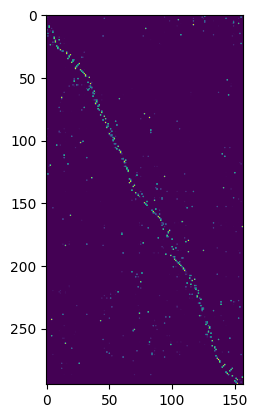

In [5]:
coupling, pred, accu_in_target = knn_ot(X_w_surf,Y_w_surf,X_d_surf,Y_d_surf, reg=0.00171)
print(accu_in_target)
plt.imshow(coupling)

reg 0.05857142857142857
0.8089171974522293


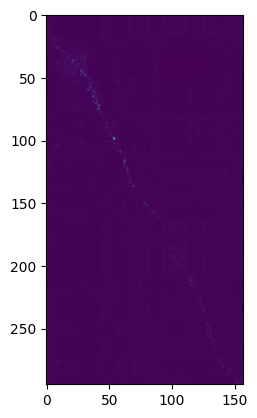

In [6]:
coupling, predicted_label, accu_in_target, best_reg = knn_ot_crossval(X_w_surf,Y_w_surf,X_d_surf,Y_d_surf, reg_range=[0.01,1.2,50], folding=5)
print('reg', best_reg)
print(accu_in_target)
plt.imshow(coupling)

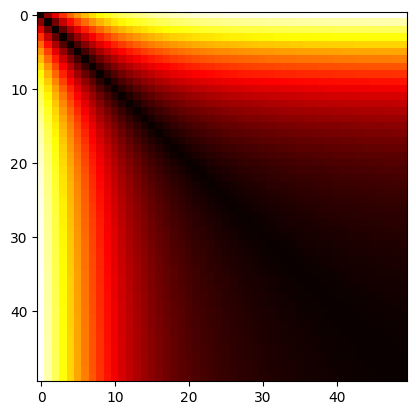

In [7]:
reg_path_matrix = knn_ot_regpath(X_w_surf,Y_w_surf,X_d_surf,Y_d_surf, reg_range=[0.0016,0.1,50])
plt.imshow(reg_path_matrix, cmap='hot')

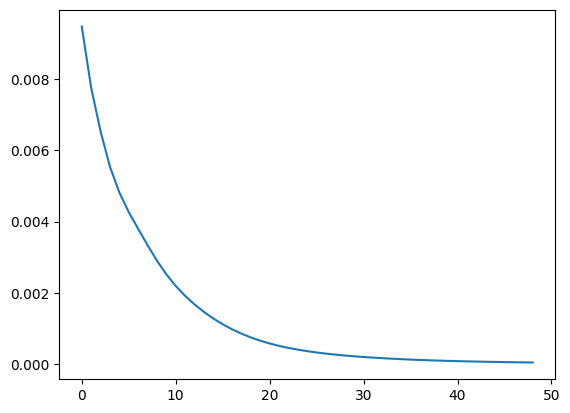

In [8]:
secon_diagonal = []
for i in range(reg_path_matrix.shape[0]-1):
    secon_diagonal.append(reg_path_matrix[i+1,i])

plt.plot(secon_diagonal)


In [79]:
trash_zeros = np.zeros_like(trash)
maxtrashind = np.argmax(trash,axis=1)
for r in range(trash_zeros.shape[0]):
    trash_zeros[r,maxtrashind[r]] = 1

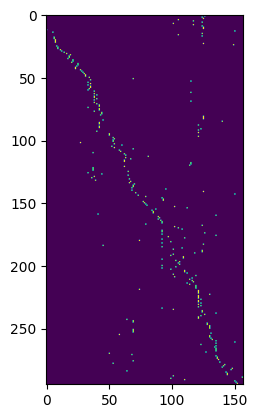

In [81]:
plt.imshow(trash_zeros)

array([ 1.,  0.,  0.,  0.,  0.,  1.,  2.,  3.,  1.,  2.,  0.,  1.,  1.,
        0.,  1.,  0.,  1.,  1.,  2.,  1.,  1.,  2.,  0.,  2.,  1.,  2.,
        0.,  2.,  1.,  1.,  1.,  2.,  0.,  5.,  2.,  4.,  1.,  4.,  8.,
        1.,  4.,  1.,  8.,  1.,  3.,  2.,  0.,  0.,  0.,  0.,  3.,  0.,
        1.,  4.,  3.,  0.,  0.,  0.,  2.,  1.,  1.,  0.,  4.,  2.,  2.,
        2.,  2.,  2.,  3., 10.,  1.,  1.,  0.,  1.,  2.,  0.,  0.,  1.,
        1.,  3.,  1.,  1.,  0.,  0.,  1.,  2.,  0.,  1.,  0.,  2.,  1.,
        1., 13.,  2.,  0.,  1.,  0.,  1.,  0.,  4.,  0.,  6.,  3.,  2.,
        0.,  4.,  2.,  0.,  2.,  2.,  4.,  0.,  3.,  0.,  3.,  5.,  2.,
        3.,  1.,  4.,  0., 16.,  0.,  6., 11.,  9.,  3.,  1.,  2.,  0.,
        6.,  2.,  1.,  0.,  1., 10.,  2.,  1.,  1.,  0.,  2.,  1.,  1.,
        1.,  2.,  0.,  0.,  1.,  1.,  1.,  4.,  1.,  1.,  0.,  0.,  0.,
        1.])

# Graphics of subalignment

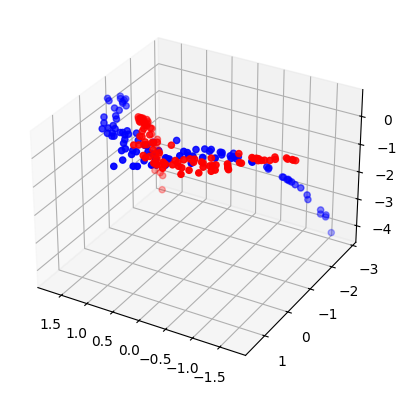

In [18]:
x_start, y_start, z_start= 0, 0, 0
scaling_factor = -1.0
x = np.linspace(-3, 3, 20)
y = np.linspace(-3, 3, 20)
X, Y = np.meshgrid(x, y)
scaler = StandardScaler()

np.random.seed(42)
random.seed(42)
S_mean = [2, 5,7]
Smatrix=np.array([[1, 0, -2], 
          [0, 1, 0.5], 
          [-2,0.5,1]])
S_cov  = Smatrix@Smatrix
S= np.random.multivariate_normal(S_mean, S_cov, 100)
S=scaler.fit_transform(S)

np.random.seed(20)
random.seed(20)
x =np.linspace(-3,3,100)
y=2-3*x-3*x**2+np.random.normal(0,2,size=100)
z=1-0.5*x*y-x**2+y**3+np.random.normal(0,2,size=100)
S= np.column_stack((x,y,z))
S=scaler.fit_transform(S)

np.random.seed(20)
random.seed(20)
x =np.linspace(-3,3,100)
y=2+3*x+-3*x**2+np.random.normal(0,3,size=100)
z=1-5*x*y-y**2+np.random.laplace(0,2,size=100)
T= np.column_stack((x,y,z))
T=scaler.fit_transform(T)

pca = PCA(n_components=2, svd_solver='full')
pca.fit(S)
eigenvectors_S=pca.components_
S_transform=pca.transform(S)
S_projected=eigenvectors_S.T@S_transform.T

pca = PCA(n_components=2, svd_solver='full')
pca.fit(T)
eigenvectors_T=pca.components_
T_transform=pca.transform(T)
T_projected=eigenvectors_T.T@T_transform.T

eigenvector_x_S1 = x_start + scaling_factor * eigenvectors_S[0][0]
eigenvector_y_S1 = y_start + scaling_factor * eigenvectors_S[0][1]
eigenvector_z_S1 = z_start + scaling_factor * eigenvectors_S[0][2]

eigenvector_x_S2 = x_start + scaling_factor * eigenvectors_S[1][0]
eigenvector_y_S2 = y_start + scaling_factor * eigenvectors_S[1][1]
eigenvector_z_S2 = z_start + scaling_factor * eigenvectors_S[1][2]

eigenvector_x_T1 = x_start + scaling_factor * eigenvectors_T[0][0]
eigenvector_y_T1 = y_start + scaling_factor * eigenvectors_T[0][1]
eigenvector_z_T1 = z_start + scaling_factor * eigenvectors_T[0][2]

eigenvector_x_T2 = x_start + scaling_factor * eigenvectors_T[1][0]
eigenvector_y_T2 = y_start + scaling_factor * eigenvectors_T[1][1]
eigenvector_z_T2 = z_start + scaling_factor * eigenvectors_T[1][2]


normal_vector_S = np.cross(eigenvectors_S[0], eigenvectors_S[1])
normal_vector_T = np.cross(eigenvectors_T[0], eigenvectors_T[1])

D = -np.dot(normal_vector_S, np.array([0, 0, 0]))  # Calculate D
Z_S = (-normal_vector_S[0] * X - normal_vector_S[1] * Y - D) / normal_vector_S[2]

D = -np.dot(normal_vector_T, np.array([0, 0, 0]))  # Calculate D
Z_T = (-normal_vector_T[0] * X - normal_vector_T[1] * Y - D) / normal_vector_T[2]

ax = plt.axes(projection='3d')
ax.scatter3D(S[:,0], S[:,1], S[:,2],c="red")
ax.scatter3D(T[:,0], T[:,1], T[:,2],c="blue")
ax.view_init(30,120)
plt.show()

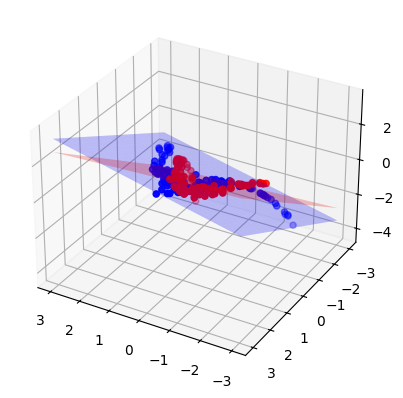

In [19]:
ax = plt.axes(projection='3d')
#ax.plot([x_start, eigenvector_x_S1], [y_start, eigenvector_y_S1], [z_start, eigenvector_z_S1], c="red")
#ax.plot([x_start, eigenvector_x_S2], [y_start, eigenvector_y_S2], [z_start, eigenvector_z_S2], c="red")
#ax.plot([x_start, eigenvector_x_T1], [y_start, eigenvector_y_T1], [z_start, eigenvector_z_T1], c="blue")
#ax.plot([x_start, eigenvector_x_T2], [y_start, eigenvector_y_T2], [z_start, eigenvector_z_T2], c="blue")
ax.scatter3D(S[:,0], S[:,1], S[:,2],c="red")
ax.scatter3D(T[:,0], T[:,1], T[:,2],c="blue")
ax.plot_surface(X, Y, Z_S, alpha=0.25,color='r')
ax.plot_surface(X, Y, Z_T, alpha=0.25,color='b')

ax.view_init(30,120)
plt.show()

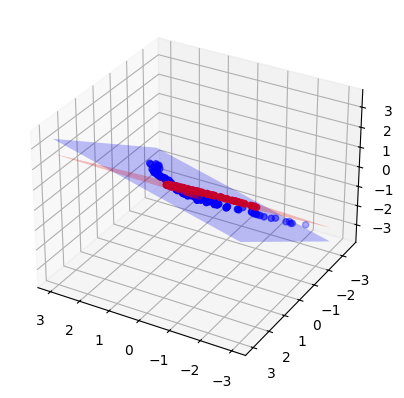

In [20]:
ax = plt.axes(projection='3d')
#ax.plot([x_start, eigenvector_x_S1], [y_start, eigenvector_y_S1], [z_start, eigenvector_z_S1], c="red")
#ax.plot([x_start, eigenvector_x_S2], [y_start, eigenvector_y_S2], [z_start, eigenvector_z_S2], c="red")
#ax.plot([x_start, eigenvector_x_T1], [y_start, eigenvector_y_T1], [z_start, eigenvector_z_T1], c="blue")
#ax.plot([x_start, eigenvector_x_T2], [y_start, eigenvector_y_T2], [z_start, eigenvector_z_T2], c="blue")
ax.scatter3D(S_projected.T[:,0], S_projected.T[:,1], S_projected.T[:,2],c="red")
ax.scatter3D(T_projected.T[:,0], T_projected.T[:,1], T_projected.T[:,2],c="blue")
ax.plot_surface(X, Y, Z_S, alpha=0.25,color='r')
ax.plot_surface(X, Y, Z_T, alpha=0.25,color='b')

ax.view_init(30,120)
plt.show()

In [21]:
pca = PCA(n_components=2, svd_solver='full')
        
pca.fit(S)
Xs=pca.components_.T
        
pca.fit(T)
Xt=pca.components_.T
        
Xa=Xs@Xs.T@Xt
normal_vector_Xa = np.cross(Xa[:,0], Xa[:,1])

In [42]:
Xs.T@Xt

array([[ 0.46413616,  0.84023513],
       [ 0.88178399, -0.40833376]])

In [26]:
np.cross(normal_vector_Xa , normal_vector_S)

array([ 5.55111512e-17, -2.77555756e-17, -3.46944695e-17])

In [29]:
D = -np.dot(normal_vector_Xa, np.array([0, 0, 0]))  # Calculate D
Z_dhfhfhsf = (-normal_vector_Xa[0] * X - normal_vector_Xa[1] * Y - D) / normal_vector_Xa[2]

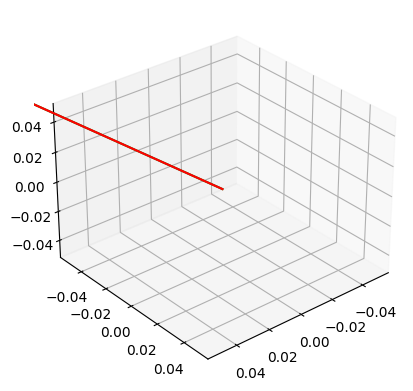

In [48]:
ax = plt.axes(projection='3d')
ax.quiver(0, 0, 0, normal_vector_Xa[0], normal_vector_Xa[1], normal_vector_Xa[2], color='g', arrow_length_ratio=0.1)
ax.quiver(0, 0, 0, normal_vector_S[0], normal_vector_S[1], normal_vector_S[2], color='r', arrow_length_ratio=0.1)
ax.view_init(30,50)
plt.show()

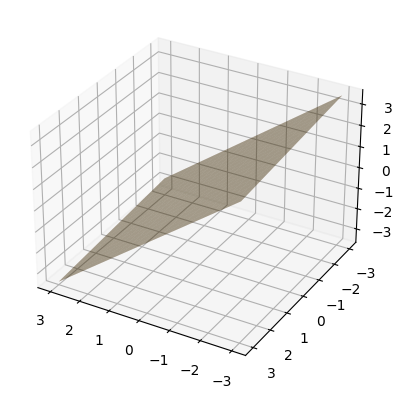

In [45]:
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z_S, alpha=0.25,color='r')
ax.plot_surface(X, Y, Z_dhfhfhsf, alpha=0.25,color='g')
ax.view_init(30,120)
plt.show()

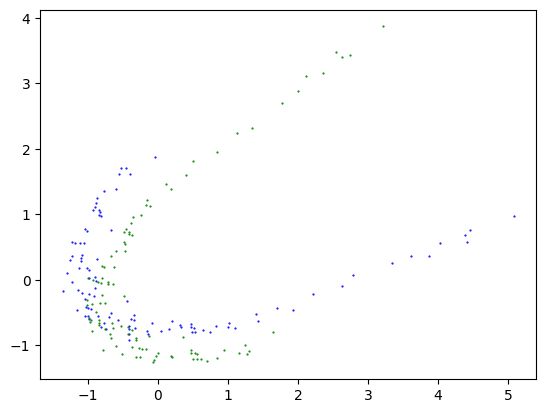

In [31]:
S_projected_on_Xs = S@Xs
S_projected_on_Xa = S@Xa
T_projected_on_Xt = T@Xt

plt.scatter(S_projected_on_Xs[:,0],S_projected_on_Xs[:,1], s=0.3, c='b')
plt.scatter(S_projected_on_Xa[:,0],S_projected_on_Xa[:,1], s=0.3, c='g')
#plt.scatter(T_projected_on_Xt[:,0],T_projected_on_Xt[:,1], s=0.3, c='k')



In [25]:
S@Xa

array([[ 1.26695362e+00, -1.13904317e+00],
       [ 1.29725881e+00, -1.08310409e+00],
       [ 1.15946212e+00, -1.12770601e+00],
       [ 1.64059858e+00, -7.98538514e-01],
       [ 1.24292310e+00, -1.00228489e+00],
       [ 8.45232074e-01, -1.19976577e+00],
       [ 7.02758160e-01, -1.24464368e+00],
       [ 9.40288531e-01, -1.06915088e+00],
       [ 6.18181040e-01, -1.21839551e+00],
       [ 5.60732911e-01, -1.21384732e+00],
       [ 5.03381335e-01, -1.20918799e+00],
       [ 5.55442309e-01, -1.14242039e+00],
       [ 5.33150934e-01, -1.11784204e+00],
       [ 4.75387879e-01, -1.11347078e+00],
       [ 4.76636247e-01, -1.07553501e+00],
       [ 2.07285378e-01, -1.18938240e+00],
       [ 1.89708329e-01, -1.16218290e+00],
       [-6.57636830e-02, -1.26549034e+00],
       [-5.22814105e-02, -1.22128214e+00],
       [-2.16479118e-02, -1.16771385e+00],
       [ 2.18925367e-03, -1.11779546e+00],
       [ 3.61476453e-01, -8.80355283e-01],
       [-2.48922728e-01, -1.18134991e+00],
       [-3.

# More dimensions

In [14]:
x_start, y_start, z_start= 0, 0, 0
scaling_factor = -1.0
x = np.linspace(-3, 3, 20)
y = np.linspace(-3, 3, 20)
X, Y = np.meshgrid(x, y)
scaler = StandardScaler()

np.random.seed(42)
random.seed(42)
x =np.linspace(-3,3,100)
y=2-3*x-3*x**2+np.random.normal(0,2,size=100)
z=1-0.5*x*y-x**2+y**3+np.random.normal(0,2,size=100)
m = 5+x*y**3*z+2*z + np.random.chisquare(5,size=100)
n = m-x-y**2+m+np.random.normal(0,2,size=100)
S= np.column_stack((x,y,z,m,n))
S=scaler.fit_transform(S)

T_mean = [2, 5,7,-2,4]
Tmatrix=np.array(  [[1  , 0,  -2, .02, -3], 
                    [0  , 1, 0.5,   0,  5], 
                    [-2 ,0.5,  1,  -2,  3],
                    [.02, 0,  -2,   1, -4],
                    [-3 , 5,  3,   -4,  1]])
T_cov  = Tmatrix@Tmatrix.T
T= np.random.multivariate_normal(T_mean, T_cov, 100)
T=scaler.fit_transform(T)

#np.random.seed(20)
#random.seed(20)
#x =np.linspace(-3,3,100)
#y=2-3*x-3*x**2+np.random.normal(0,2,size=100)
#z=1-0.5*x*y-x**2+y**3+np.random.normal(0,2,size=100)
#S= np.column_stack((x,y,z))
#S=scaler.fit_transform(S)

#np.random.seed(20)
#random.seed(20)
#x =np.linspace(-3,3,100)
#y=2+3*x+-3*x**2+np.random.normal(0,3,size=100)
#z=1-5*x*y-y**2+np.random.laplace(0,2,size=100)
#T= np.column_stack((x,y,z))
#T=scaler.fit_transform(T)

pca = PCA(n_components=2, svd_solver='full')
pca.fit(S)
eigenvectors_S=pca.components_
S_transform=pca.transform(S)
S_projected=eigenvectors_S.T@S_transform.T

pca = PCA(n_components=2, svd_solver='full')
pca.fit(T)
eigenvectors_T=pca.components_
T_transform=pca.transform(T)
T_projected=eigenvectors_T.T@T_transform.T


M = eigenvectors_S.T@eigenvectors_T
Xa=eigenvectors_S@M

#eigenvector_x_S1 = x_start + scaling_factor * eigenvectors_S[0][0]
#eigenvector_y_S1 = y_start + scaling_factor * eigenvectors_S[0][1]
#eigenvector_z_S1 = z_start + scaling_factor * eigenvectors_S[0][2]
#
#eigenvector_x_S2 = x_start + scaling_factor * eigenvectors_S[1][0]
#eigenvector_y_S2 = y_start + scaling_factor * eigenvectors_S[1][1]
#eigenvector_z_S2 = z_start + scaling_factor * eigenvectors_S[1][2]
#
#eigenvector_x_T1 = x_start + scaling_factor * eigenvectors_T[0][0]
#eigenvector_y_T1 = y_start + scaling_factor * eigenvectors_T[0][1]
#eigenvector_z_T1 = z_start + scaling_factor * eigenvectors_T[0][2]
#
#eigenvector_x_T2 = x_start + scaling_factor * eigenvectors_T[1][0]
#eigenvector_y_T2 = y_start + scaling_factor * eigenvectors_T[1][1]
#eigenvector_z_T2 = z_start + scaling_factor * eigenvectors_T[1][2]
#
#print(eigenvectors_S[0])
#print(eigenvectors_S[1])
#normal_vector_S = np.cross(eigenvectors_S[0], eigenvectors_S[1])
#normal_vector_T = np.cross(eigenvectors_T[0], eigenvectors_T[1])
#
#D = -np.dot(normal_vector_S, np.array([0, 0, 0]))  # Calculate D
#Z_S = (-normal_vector_S[0] * X - normal_vector_S[1] * Y - D) / normal_vector_S[2]
#
#D = -np.dot(normal_vector_T, np.array([0, 0, 0]))  # Calculate D
#Z_T = (-normal_vector_T[0] * X - normal_vector_T[1] * Y - D) / normal_vector_T[2]
#
#ax = plt.axes(projection='3d')
#ax.scatter3D(S[:,0], S[:,1], S[:,2],c="red")
#ax.scatter3D(T[:,0], T[:,1], T[:,2],c="blue")
#ax.view_init(30,120)
#plt.show()

In [15]:
M

array([[-0.01341316,  0.11909026, -0.30156014, -0.04589703, -0.87623876],
       [-0.17665489,  0.15126431,  0.23057657, -0.17336654,  0.26245093],
       [-0.25813439,  0.25894081,  0.22452276, -0.26486099,  0.06779329],
       [ 0.29135001, -0.31770723, -0.17795848,  0.30668318,  0.13541388],
       [ 0.29135002, -0.31770724, -0.17795847,  0.30668319,  0.13541393]])

In [16]:
Xa

array([[ 0.47954373, -0.45970529, -0.48036896,  0.48554933, -0.30363856],
       [ 0.19449347, -0.30766954,  0.16461664,  0.23380513,  0.88642443]])

In [17]:
eigenvectors_S

array([[ 0.32745612, -0.4288808 , -0.49986469,  0.47904543,  0.47904542],
       [-0.87634144,  0.14916803, -0.0947457 ,  0.31685785,  0.31685791]])